In [1]:
import pickle

import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

warnings.filterwarnings('ignore')

### raw data

In [86]:
filename = '../../../../[CMU]14226830/VAH30.csv'
dataframe = pd.read_csv(filename)
dataframe.shape

(591239, 10)

591239 records for vah 30, 10 features

In [87]:
cycle_number = np.array(dataframe['cycleNumber'])
index = np.where(np.diff(cycle_number) == 1)[0] + 1
index[0:10], len(index)

(array([19137, 19398, 19659, 19919, 20179, 20439, 20699, 20959, 21220,
        21481]),
 881)

In [88]:
dataframe.iloc[19135:19140]['cycleNumber']

19135    0
19136    0
19137    1
19138    1
19139    1
Name: cycleNumber, dtype: int64

index = cycle id change = new cycle begin, 881 cycles in total

In [89]:
all_current = np.array(dataframe['I_mA']) / 1000
all_current, all_current.shape

(array([1.4883409, 1.4891287, 1.4887347, ..., 0.       , 0.       ,
        0.       ]),
 (591239,))

In [90]:
j = 842
c = all_current[index[j]:index[j + 1]]
c[0:10], c.shape

(array([2.9912346, 2.9937952, 2.9926133, 2.9918254, 2.9928103, 2.9930073,
        2.9928103, 2.9934011, 2.9926133, 2.9926133]),
 (349,))

about 300 records in each cycle

In [91]:
indices = np.argmax(c < 0)
indices

193

In [92]:
c[indices - 10:indices + 10]

array([  0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
       -12.801462 , -15.591398 , -15.750334 , -15.760181 , -15.706415 ,
       -15.641816 , -15.589035 , -15.55063  , -15.537436 ,  -9.7320615])

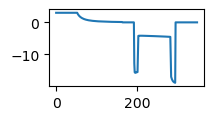

In [93]:
# plot c
import matplotlib.pyplot as plt

# small figure
plt.figure(figsize=(2, 1))
plt.plot(c)
plt.show()

before indices, charge; after indices, discharge

In [94]:
charge_current, discharge_current = [], []
charge_current.append(c[:indices])
discharge_current.append(c[indices:])
charge_current[0][0:10], discharge_current[0][0:10]

(array([2.9912346, 2.9937952, 2.9926133, 2.9918254, 2.9928103, 2.9930073,
        2.9928103, 2.9934011, 2.9926133, 2.9926133]),
 array([-12.801462 , -15.591398 , -15.750334 , -15.760181 , -15.706415 ,
        -15.641816 , -15.589035 , -15.55063  , -15.537436 ,  -9.7320615]))

data split to charge and discharge

### processed data

In [2]:
with open('../../../../[CMU]14226830/pkl_data/CMU.pkl', 'rb') as f:
    data = pickle.load(f)

#### check data format

In [96]:
data.keys(), len(data.keys())

(dict_keys(['CMU_battery_1', 'CMU_battery_2', 'CMU_battery_5', 'CMU_battery_6', 'CMU_battery_7', 'CMU_battery_9', 'CMU_battery_10', 'CMU_battery_11', 'CMU_battery_12', 'CMU_battery_13', 'CMU_battery_15', 'CMU_battery_16', 'CMU_battery_17', 'CMU_battery_20', 'CMU_battery_22', 'CMU_battery_23', 'CMU_battery_24', 'CMU_battery_25', 'CMU_battery_26', 'CMU_battery_27', 'CMU_battery_28', 'CMU_battery_30']),
 22)

22 batteries

In [97]:
data['CMU_battery_30'].keys()

dict_keys(['discharge_time', 'discharge_current', 'discharge_voltage', 'discharge_capacity', 'discharge_temperature', 'life', 'charge_protocol', 'material'])

features include: time, 4 physical features and life

In [99]:
data['CMU_battery_30']['discharge_current'][0][0:10]

array([-12.788268 , -14.014649 , -14.138528 , -14.211005 , -14.267134 ,
       -14.31972  , -14.36994  , -14.419177 , -14.441037 ,  -8.8840117])

data example

In [98]:
len(data['CMU_battery_30']['discharge_current']), len(data['CMU_battery_30']['discharge_current'][842])

(880, 156)

about 800 cycles and 150 samples each

##### check cycle and samples numbers in detail

[['1', 811], ['2', 597], ['5', 1746], ['6', 1269], ['7', 369], ['9', 887], ['10', 1370], ['11', 2158], ['12', 2254], ['13', 999], ['15', 531], ['16', 536], ['17', 960], ['20', 585], ['22', 756], ['23', 667], ['24', 767], ['25', 528], ['26', 1114], ['27', 560], ['28', 1131], ['30', 880]]


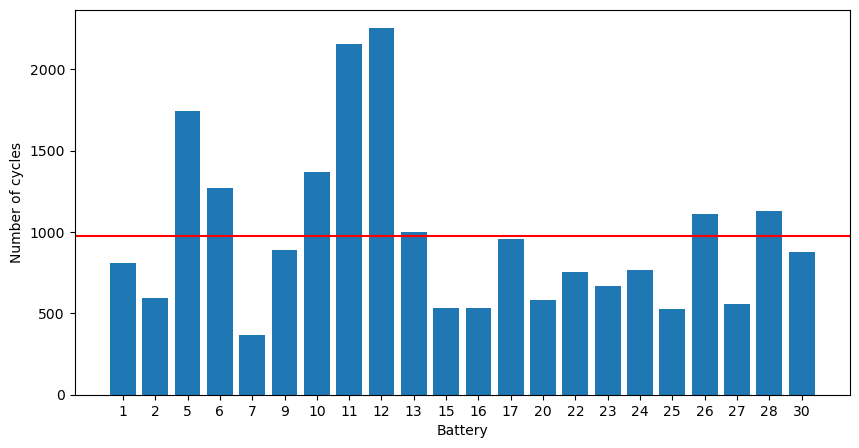

In [61]:
battery_cycles = []
for battery_name in data.keys():
    battery_cycles.append([battery_name.split("_")[2],len(data[battery_name]['discharge_time'])])
print(battery_cycles)
average_cycles = np.mean([i[1] for i in battery_cycles])
# plot barchart cycles against discharge time, name as x, time as y
plt.figure(figsize=(10, 5))
plt.bar([i[0] for i in battery_cycles], [i[1] for i in battery_cycles])
plt.xlabel('Battery')
plt.ylabel('Number of cycles')
plt.axhline(y=average_cycles, color='r', linestyle='-')
plt.show()

cycles numbers of all batterys

In [160]:
for feature in data['CMU_battery_30'].keys():
    if type(data['CMU_battery_30'][feature]) == list:
        print(feature, len(data['CMU_battery_30'][feature]))
    else:
        print(feature, "=", data['CMU_battery_30'][feature])

discharge_time 880
discharge_current 880
discharge_voltage 880
discharge_capacity 880
discharge_temperature 880
life = 879
charge_protocol = CCCV
material = lithium-ion battery


for one battery, each feature have same number of cycles (indeed)

In [63]:
for battery_name in data.keys():
    print(battery_name, data[battery_name]['life'], len(data[battery_name]['discharge_current']))

CMU_battery_1 810 811
CMU_battery_2 596 597
CMU_battery_5 1672 1746
CMU_battery_6 973 1269
CMU_battery_7 317 369
CMU_battery_9 740 887
CMU_battery_10 1369 1370
CMU_battery_11 2157 2158
CMU_battery_12 2253 2254
CMU_battery_13 998 999
CMU_battery_15 530 531
CMU_battery_16 535 536
CMU_battery_17 959 960
CMU_battery_20 584 585
CMU_battery_22 682 756
CMU_battery_23 666 667
CMU_battery_24 766 767
CMU_battery_25 527 528
CMU_battery_26 1113 1114
CMU_battery_27 559 560
CMU_battery_28 592 1131
CMU_battery_30 879 880


different batteries have different number of cycles

battery life is cycle number or slightly smaller than that (wrong)

21475 507.96027939464494 2396.006324998972 133.0
3 48960


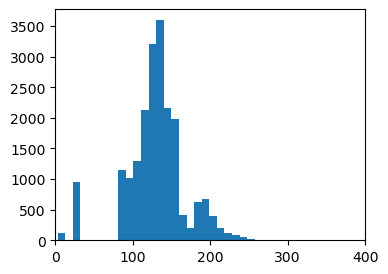

In [115]:
# array data[battery_name]['discharge_current'][n][m], print the average of m across n
cycle_samples_all = []
for battery_name in data.keys():
    for cycle in range(len(data[battery_name]['discharge_current'])):
        cycle_samples = len(data[battery_name]['discharge_current'][cycle])
        cycle_samples_all.append(cycle_samples)
print(len(cycle_samples_all), np.mean(cycle_samples_all), np.std(cycle_samples_all), np.median(cycle_samples_all))
print(np.min(cycle_samples_all), np.max(cycle_samples_all))
plt.figure(figsize=(4, 3))
plt.hist(cycle_samples_all, bins=5000)
plt.xlim(0, 400)
plt.show()

varied number of samples, about 133

#### battery life

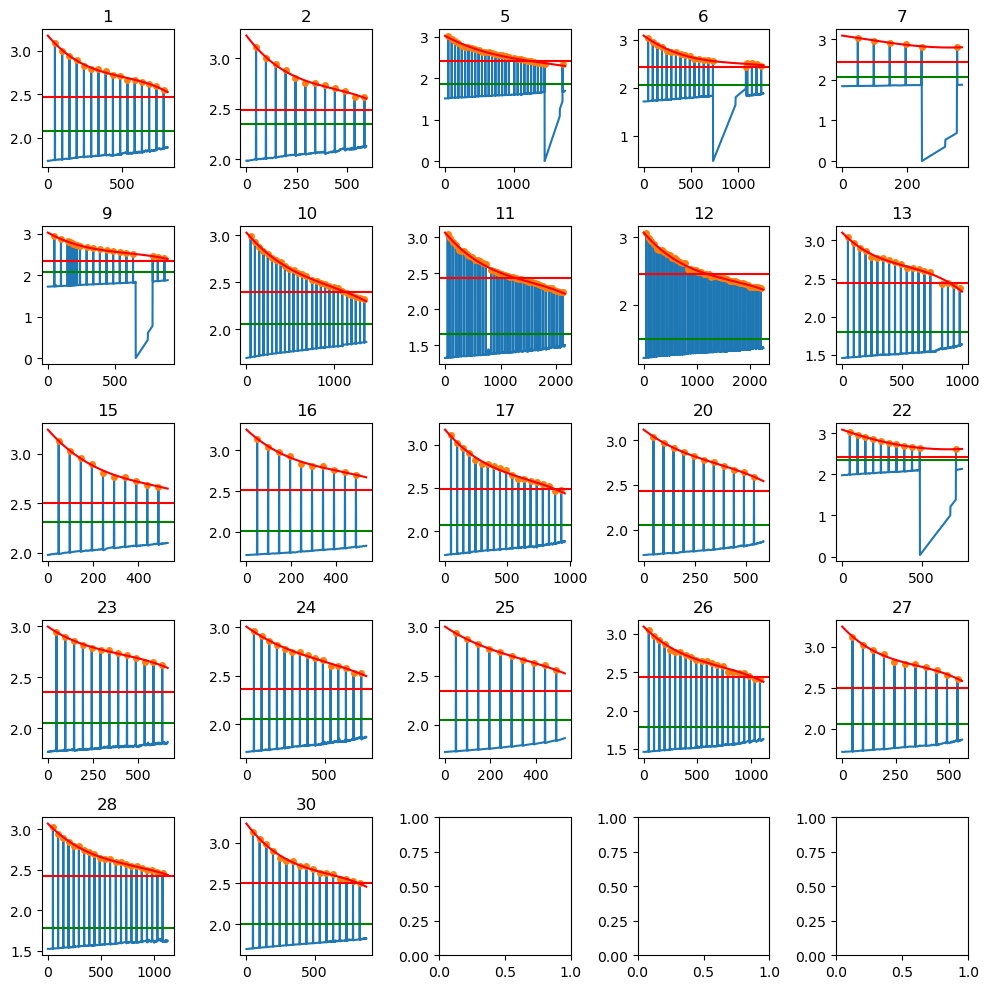

In [3]:
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for i, example_battery in enumerate(list(data.keys())):
    # example_battery = 'CMU_battery_9'
    # print(len(data[example_battery]['discharge_capacity']))
    cycle = [] # x
    cycle_max_q = [] # y
    for j in range(len(data[example_battery]['discharge_capacity'])):
        cycle.append(j)
        cycle_max_q.append(np.max(data[example_battery]['discharge_capacity'][j]))
    # peak: capacity > 1.1 * last capacity (derived from empirical observation)
    capacity_peak_mask = np.array(cycle_max_q) > cycle_max_q[-1]*1.1
    # capacity_peak: (cycle, capacity)
    capacity_peak = np.array(cycle)[capacity_peak_mask], np.array(cycle_max_q)[capacity_peak_mask]
    # die: capacity < 0.8 * first peak capacity
    die_capacity = np.array(capacity_peak[1])[0] * 0.8
    # fit capacity peak with cubic polynomial function
    coeffs = np.polyfit(capacity_peak[0], capacity_peak[1], 3)
    f = np.poly1d(coeffs)
    capacity_peak_fit = f(cycle)
    # (or interpolate capacity peak with cubic spline function)
    # f = interp1d(capacity_peak[0], capacity_peak[1], kind='cubic')
    # capacity_peak_fit = f(cycle)

    # plt.figure(figsize=(4, 3))
    # plt.axhline(y=np.mean(cycle_max_q), color='r', linestyle='-')
    # plt.plot(cycle_max_q)
    # plt.show()
    
    # plot cycle_max_q with line and capacity_peak with circle
    axs[i // 5, i % 5].plot(cycle_max_q, linestyle='-')
    axs[i // 5, i % 5].plot(capacity_peak[0], capacity_peak[1], linestyle='', marker='o', markersize=4)
    axs[i // 5, i % 5].plot(cycle, capacity_peak_fit, linestyle='-', color='r')
    axs[i // 5, i % 5].axhline(y=cycle_max_q[-1]*1.1, color='g', linestyle='-')
    axs[i // 5, i % 5].axhline(y=die_capacity, color='r', linestyle='-')
    axs[i // 5, i % 5].set_title(example_battery.split("_")[2])

    plt.tight_layout()

    data[example_battery]['SoH'] = np.array(capacity_peak_fit) / capacity_peak_fit[0]
plt.show()


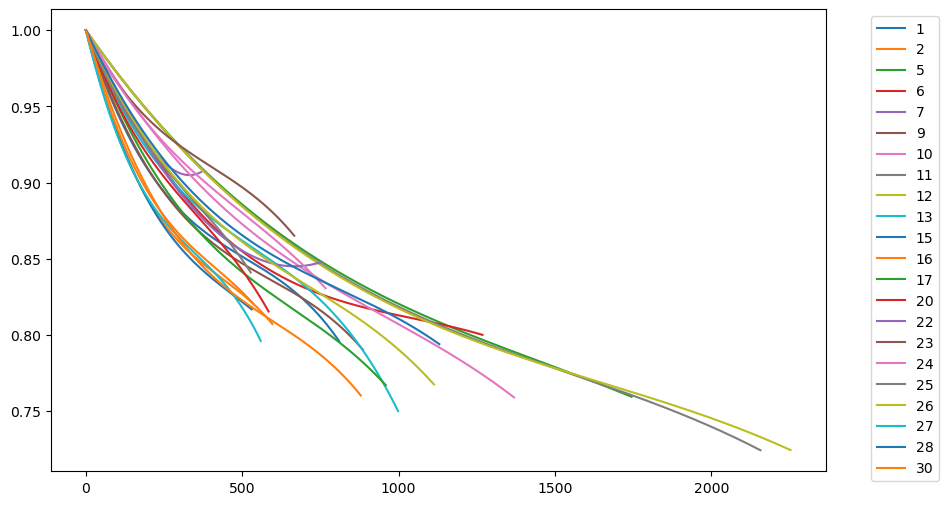

In [60]:
# plot soh for each battery in one line chart
plt.figure(figsize=(10, 6))
for i, example_battery in enumerate(list(data.keys())):
    soh = data[example_battery]['SoH']
    plt.plot(soh, label=example_battery.split("_")[2])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()


#### time align

In [3]:
# for cycle in range(len(data['CMU_battery_7']['discharge_time'])):
for cycle in range(20):
    discharge_time = -data['CMU_battery_7']['discharge_time'][cycle][0] + data['CMU_battery_7']['discharge_time'][cycle][-1]
    print(discharge_time)
    # print(discharge_time, discharge_time * 60, discharge_time * 60 * 60)

2227.1301057829987
2272.982107960801
2292.430108884604
2261.332107407594
2263.410110005898
2262.2641137723986
2162.846108772501
2231.230112211604
2295.2521154315036
2297.414115540203
2326.64011701
2333.768117368003
2269.574114139992
2189.2641101010086
2232.5861122800125
2284.1242382519995
2300.4062399510003
2278.9462377120217
2299.190239824995
2234.7462331019924


21475 2435.0555301552017 5591.329680638143 1832.140191100052


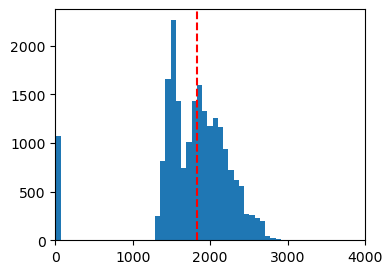

In [119]:
# draw histgram of disdischarge time
discharge_time_all = []
for battery_name in data.keys():
    for cycle in range(len(data[battery_name]['discharge_time'])):
        discharge_time = -data[battery_name]['discharge_time'][cycle][0] + data[battery_name]['discharge_time'][cycle][-1]
        # discharge_time *= 60 * 60
        discharge_time_all.append(discharge_time)
print(len(discharge_time_all), np.mean(discharge_time_all), np.std(discharge_time_all), np.median(discharge_time_all))

plt.figure(figsize=(4, 3))
plt.hist(discharge_time_all, bins=5000)
plt.axvline(x=np.median(discharge_time_all), color='r', linestyle='--')
plt.xlim(0, 4000)
plt.show()

cycle(discharge time): 1300 - 1800 - 2700

&lt 1000 or &gt 3000, drop

&lt 2500, pad

&gt 2500, trun

In [4]:
MAX_TIME = 2500
MAX_POINT = 500

5s/sample

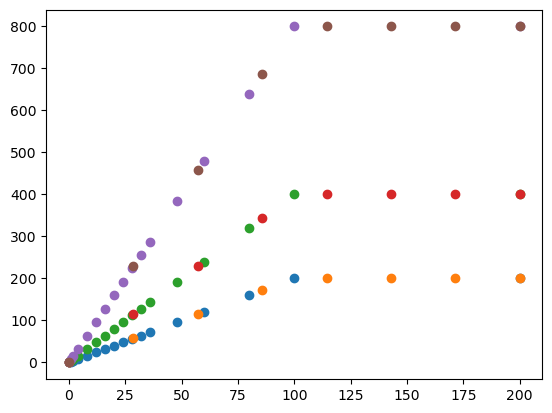

In [26]:
# to see how to pad and interpolate

import numpy as np
from scipy.interpolate import interp1d

# Generate some sample data
x = np.array([0, 1, 2, 4, 8, 12, 16, 20, 24, 28, 32, 36, 48, 60, 80, 100]) # time
y = 2*x # capacity
z = 4*x # voltage
w = 8*x # current

# append a value 200 to x
x = np.append(x, 200)
# append their last value to y, z, w
y = np.append(y, y[-1])
z = np.append(z, z[-1])
w = np.append(w, w[-1])

# Create an interpolation function
fy = interp1d(x, y)
fz = interp1d(x, z)
fw = interp1d(x, w)

# Evaluate the interpolation function at some new points
x_new = np.linspace(0, 200, num=8, endpoint=True)
y_new = fy(x_new)
z_new = fz(x_new)
w_new = fw(x_new)

# Plot the original data and the interpolated data
import matplotlib.pyplot as plt
plt.plot(x, y, 'o', x_new, y_new, 'o', x, z, 'o', x_new, z_new, 'o', x, w, 'o', x_new, w_new, 'o')
plt.show()

test padding and interpolate

In [33]:
list(data['CMU_battery_7'].keys())[0:5]

['discharge_time',
 'discharge_current',
 'discharge_voltage',
 'discharge_capacity',
 'discharge_temperature']

In [23]:
# for battery_name in list(data.keys())[0:2]:
#     for cccc in range(len(data[battery_name]['discharge_time'])):
battery_name = 'CMU_battery_2'
cccc = 590
t = data[battery_name]['discharge_time'][cccc][-1] - data[battery_name]['discharge_time'][cccc][0]
if t > MAX_TIME and t < 3000:
    print(battery_name, cccc, t)
    time = data[battery_name]['discharge_time'][cccc]
    cycle_time = time[-1]
    current = data[battery_name]['discharge_current'][cccc]
    voltage = data[battery_name]['discharge_voltage'][cccc]
    capacity = data[battery_name]['discharge_capacity'][cccc]
    temperature = data[battery_name]['discharge_temperature'][cccc]
    time = time - time[0]
    if cycle_time > MAX_TIME:
        cut = np.argmax(time > MAX_TIME)
        print(cut, time[cut-2], time[cut-1], time[cut])
        print(len(time[:MAX_POINT]), time[:MAX_POINT][-5:])
        time = time[:cut-1]
        time = np.append(time, MAX_TIME)
        print(len(time[:MAX_POINT]), time[:MAX_POINT][-5:])
        cut_current = (current[cut-1]+current[cut])/2
        current = current[:cut-1]
        current = np.append(current, cut_current)
        cut_voltage = (voltage[cut-1]+voltage[cut])/2
        voltage = voltage[:cut-1]
        voltage = np.append(voltage, cut_voltage)
        cut_capacity = (capacity[cut-1]+capacity[cut])/2
        capacity = capacity[:cut-1]
        capacity = np.append(capacity, cut_capacity)
        cut_temperature = (temperature[cut-1]+temperature[cut])/2
        print(cut_temperature)
        print(temperature[cut-2], temperature[cut-1], temperature[cut])
        print(temperature[-5:])
        temperature = temperature[:cut-1]
        temperature = np.append(temperature, cut_temperature)
        print(temperature[-5:])
    print(len(time), len(current), len(voltage), len(capacity), len(temperature))

CMU_battery_2 590 2833.05629550945
166 2469.950257629156 2499.9502607593313 2529.9502638895065
178 [2739.95028579 2769.95028892 2799.95029205 2829.95029518 2833.05629551]
166 [2379.95024824 2409.95025137 2439.9502545  2469.95025763 2500.        ]
28.4742775
28.754765 28.486128 28.462427
[27.68022  27.617012 27.372082 27.245665 27.190357]
[29.292038  28.912785  28.857477  28.754765  28.4742775]
166 166 166 166 166


study how to truncate: cut = first that exceeds, discard exceed, replace last with mean of last and first exceeds/max time

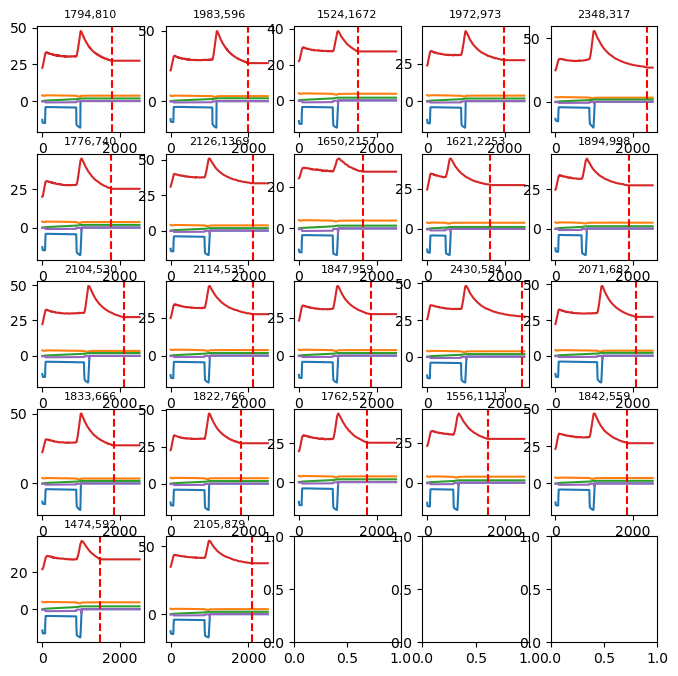

In [5]:
new_data = {}
battery_names = list(data.keys())
fig, axs = plt.subplots(5,5, figsize=(8, 8))
for i, battery_name in enumerate(battery_names):
    # battery_name = 'CMU_battery_7'
    # new_data[battery_name] = []
    new_data[battery_name] = {
        'time': [],
        'current': [],
        'voltage': [],
        'capacity': [],
        # 'temperature': [],
        'delta_time': [],
        'delta_voltage': [],
        'ir': [],
        'life': 0,
    }
    life = data[battery_name]['life']
    for cycle_num in range(len(data[battery_name]['discharge_time'])):
        # raw time starts from the first cycle without stop
        raw_time = data[battery_name]['discharge_time'][cycle_num]
        # time is relative time in a cycle and starts from 0
        time = raw_time.copy()
        time = time - time[0]
        # time *= 60 * 60
        # cycle_time is time length of a cycle
        cycle_time = time[-1]
        # raw data
        current = data[battery_name]['discharge_current'][cycle_num]
        voltage = data[battery_name]['discharge_voltage'][cycle_num]
        capacity = data[battery_name]['discharge_capacity'][cycle_num]
        temperature = data[battery_name]['discharge_temperature'][cycle_num]
        # print((time[-1] - time[0]))
        # print(time[-1])
        # drop if time[-1] < 1000 or time[-1] > 300
        if cycle_time < 1000 or cycle_time > 3000:
            continue
        # truncate or pad
        if cycle_time > MAX_TIME:
            # cut is the first index of time > MAX_TIME
            cut = np.argmax(time > MAX_TIME)
            # time use MAX_TIME
            time = time[:cut-1]
            time = np.append(time, MAX_TIME)
            raw_time = raw_time[:cut-1]
            raw_time = np.append(raw_time, raw_time[0]+MAX_TIME)
            # current, voltage, capacity, temperature use the average of last in and first out
            cut_current = (current[cut-1]+current[cut])/2
            current = current[:cut-1]
            current = np.append(current, cut_current)
            cut_voltage = (voltage[cut-1]+voltage[cut])/2
            voltage = voltage[:cut-1]
            voltage = np.append(voltage, cut_voltage)
            cut_capacity = (capacity[cut-1]+capacity[cut])/2
            capacity = capacity[:cut-1]
            capacity = np.append(capacity, cut_capacity)
            cut_temperature = (temperature[cut-1]+temperature[cut])/2
            temperature = temperature[:cut-1]
            temperature = np.append(temperature, cut_temperature)
        elif cycle_time < MAX_TIME:
            # time use max_time
            time = np.append(time, MAX_TIME)
            raw_time = np.append(raw_time, raw_time[0]+MAX_TIME)
            # current, voltage, capacity, temperature use last value
            current = np.append(current, current[-1])
            voltage = np.append(voltage, voltage[-1])
            capacity = np.append(capacity, capacity[-1])
            temperature = np.append(temperature, temperature[-1])
        # interpolate
        f_time = interp1d(time, time)
        f_raw_time = interp1d(time, raw_time)
        f_current = interp1d(time, current)
        f_voltage = interp1d(time, voltage)
        f_capacity = interp1d(time, capacity)
        f_temperature = interp1d(time, temperature)
        time = np.linspace(time[0], MAX_TIME, num=MAX_POINT, endpoint=True)
        raw_time = f_raw_time(time)
        current = f_current(time)
        voltage = f_voltage(time)
        capacity = f_capacity(time)
        temperature = f_temperature(time)
        # derived data
        if cycle_num == 0:
            time_init = raw_time
            voltage_init = voltage
        delta_time = raw_time - time_init
        delta_voltage = voltage - voltage_init
        ir = np.divide(np.array(voltage), np.array(current),
                        out=np.zeros_like(voltage), where=np.array(current) != 0)
        # plot for cycle 140
        if cycle_num == 140:
            # plt.figure(figsize=(4, 3))
            axs[i//5, i%5].plot(time, current, '-', time, voltage, '-', time, capacity, '-', time, temperature, '-', time, ir, '-')
            # draw vertical line
            axs[i//5, i%5].axvline(x=cycle_time, color='r', linestyle='--')
            # title: interger part of cycle_time, small font
            axs[i//5, i%5].set_title(str(int(cycle_time)) + ','+ str(int(life)), fontsize=8)
            # print(cycle_time)
            # legend
            # if i == 21:
            #     axs[i//5, i%5].legend(['current', 'voltage', 'capacity', 'temperature'], loc='center left', bbox_to_anchor=(1.05, 0.5))
        # new_data[battery_name].append({
        #     'time': time,
        #     'current': current,
        #     'voltage': voltage,
        #     'capacity': capacity,
        #     'temperature': temperature,
        #     'life': life,
        # })
        # new_data[battery_name]['time'].append(time)
        new_data[battery_name]['time'].append(raw_time)
        new_data[battery_name]['current'].append(current)
        new_data[battery_name]['voltage'].append(voltage)
        new_data[battery_name]['capacity'].append(capacity)
        # new_data[battery_name]['temperature'].append(temperature)
        new_data[battery_name]['delta_time'].append(delta_time)
        new_data[battery_name]['delta_voltage'].append(delta_voltage)
        new_data[battery_name]['ir'].append(ir)
        # label data
        new_data[battery_name]['life'] = life
        new_data[battery_name]['soh'] = data[battery_name]['SoH']
plt.show()

1. discard
2. pad or truncate
3. interpolate

In [8]:
new_data['CMU_battery_7']['time'][140][-10:] - new_data['CMU_battery_7']['time'][140][0], len(new_data['CMU_battery_7']['time'][140])

(array([2454.90981964, 2459.91983968, 2464.92985972, 2469.93987976,
        2474.9498998 , 2479.95991984, 2484.96993988, 2489.97995992,
        2494.98997996, 2500.        ]),
 500)

In [64]:
new_data['CMU_battery_7']['delta_voltage'][140][-100:], len(new_data['CMU_battery_7']['delta_voltage'][140])

(array([-0.10828187, -0.1082292 , -0.10817653, -0.10812385, -0.10807118,
        -0.10801851, -0.10799294, -0.10797323, -0.10795353, -0.10793382,
        -0.10791412, -0.10789441, -0.10789114, -0.10789114, -0.10789114,
        -0.10789114, -0.10789114, -0.10789114, -0.10786886, -0.10784254,
        -0.10781622, -0.1077899 , -0.10776358, -0.10773726, -0.10772786,
        -0.10772125, -0.10771464, -0.10770802, -0.10770141, -0.1076948 ,
        -0.10764616, -0.10759122, -0.10759488, -0.1076015 , -0.10760811,
        -0.10761472, -0.1076271 , -0.10764024, -0.10765339, -0.10766653,
        -0.10767967, -0.10769282, -0.10770445, -0.10771591, -0.10772737,
        -0.1077335 , -0.1077335 , -0.1077335 , -0.1077335 , -0.1077335 ,
        -0.1077335 , -0.1077335 , -0.1077335 , -0.1077335 , -0.1077335 ,
        -0.1077335 , -0.1077335 , -0.1077335 , -0.1077335 , -0.1077335 ,
        -0.1077335 , -0.1077335 , -0.1077335 , -0.1077335 , -0.1077335 ,
        -0.1077335 , -0.1077335 , -0.1077335 , -0.1

In [14]:
new_data['CMU_battery_7']['soh'][-100:], len(new_data['CMU_battery_7']['soh'])

(array([0.90988981, 0.90973506, 0.90958253, 0.90943223, 0.90928417,
        0.90913836, 0.9089948 , 0.90885352, 0.90871452, 0.90857781,
        0.90844339, 0.90831128, 0.90818149, 0.90805403, 0.90792891,
        0.90780613, 0.90768571, 0.90756766, 0.90745199, 0.9073387 ,
        0.9072278 , 0.90711932, 0.90701325, 0.90690961, 0.9068084 ,
        0.90670964, 0.90661333, 0.90651949, 0.90642812, 0.90633924,
        0.90625285, 0.90616897, 0.9060876 , 0.90600875, 0.90593244,
        0.90585867, 0.90578745, 0.9057188 , 0.90565272, 0.90558922,
        0.90552832, 0.90547002, 0.90541433, 0.90536126, 0.90531082,
        0.90526303, 0.90521788, 0.9051754 , 0.90513559, 0.90509846,
        0.90506402, 0.90503228, 0.90500324, 0.90497693, 0.90495335,
        0.90493251, 0.90491442, 0.90489908, 0.90488652, 0.90487673,
        0.90486974, 0.90486554, 0.90486414, 0.90486557, 0.90486982,
        0.90487691, 0.90488685, 0.90489965, 0.90491531, 0.90493385,
        0.90495527, 0.9049796 , 0.90500682, 0.90

In [65]:
np.diff(new_data['CMU_battery_7']['time'][140])[0:10]

array([5.01002004, 5.01002004, 5.01002004, 5.01002004, 5.01002004,
       5.01002004, 5.01002004, 5.01002004, 5.01002004, 5.01002004])

In [43]:
len(new_data['CMU_battery_7']['time']), len(new_data['CMU_battery_7']['time'][140])

(255, 500)

each cycle has 500 samples

In [64]:
new_data['CMU_battery_7']['life'], new_data['CMU_battery_9']['life']

(317, 740)

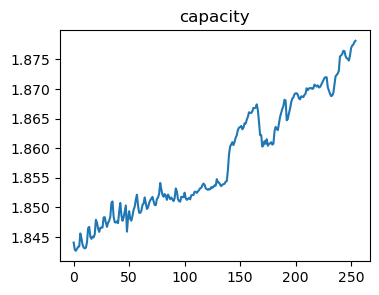

0.9811282705823918


In [34]:
# draw capacity change
cycles_capacity = []
cycles_current = []
cycles_voltage = []
cycles_temperature = []
for i in range(len(new_data['CMU_battery_7']['capacity'])):
    # get highest capacity in each cycle
    cycle_capacity = np.max(new_data['CMU_battery_7']['capacity'][i])
    cycles_capacity.append(cycle_capacity)
plt.figure(figsize=(4, 3))
plt.plot(cycles_capacity, '-')
plt.title('capacity')
plt.show()
max_capacity = np.max(cycles_capacity)
min_capacity = np.min(cycles_capacity)
print(min_capacity/max_capacity)



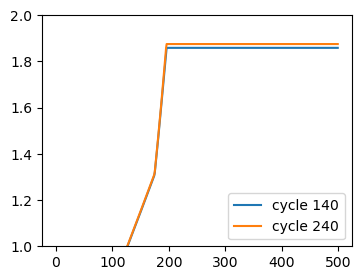

In [35]:
# plot capacity change for battery 7 in cycle 140 and 240
plt.figure(figsize=(4, 3))
plt.plot(new_data['CMU_battery_7']['capacity'][140], '-')
plt.plot(new_data['CMU_battery_7']['capacity'][240], '-')
plt.legend(['cycle 140', 'cycle 240'])
plt.ylim(1.0, 2.0)
plt.show()


...capacity increasing

#### sliding window

In [6]:
# from src.AEDataset import myDataset
import torch.utils.data as data
class myDataset(data.Dataset):
    def __init__(self, cycles, labels):
        super(myDataset, self).__init__()
        self.cycles, self.labels, = cycles, labels
        self.cycle_len = cycles.shape[1]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.cycles[index],  self.labels[index]

In [7]:
window, shift = 200, 10

In [24]:
import random
CMU_dataset = {}
battery_names = list(new_data.keys())
# random.shuffle(battery_names)
# train_battery = battery_names[:int(len(battery_names)*0.75)]
# test_battery = battery_names[int(len(battery_names)*0.75):]
# train: 5 10 11 13 16 17 20 24 25 26 27 30
train_battery = ['CMU_battery_5', 'CMU_battery_10', 'CMU_battery_11', 'CMU_battery_13', 'CMU_battery_16', 'CMU_battery_17', 'CMU_battery_20', 'CMU_battery_24', 'CMU_battery_25', 'CMU_battery_26', 'CMU_battery_27', 'CMU_battery_30']
# test: 12 15 28
test_battery = ['CMU_battery_12', 'CMU_battery_15', 'CMU_battery_28']
train_data, test_data = [], []
train_target, test_target = [], []
for b_idx, battery_name in enumerate(battery_names):
    # battery_name = 'CMU_battery_7'
    life = new_data[battery_name]['life']
    soh = new_data[battery_name]['soh']
    # for each window
    for i in range(0, len(new_data[battery_name]['time'])-window, shift):
        # win_data is four features' data in a window (4*window*samples)
        win_data = []
        for f_idx, f in enumerate(['voltage', 'current', 'capacity', 'time', 'ir', 'delta_voltage', 'delta_time']):
            win_data.append(new_data[battery_name][f][i: i + window])
        # tagert is life, rul, and soh, each is a vertor of length window
        # life is the same for all samples in a window
        win_life = [life] * window
        # rul 
        win_rul = [life-j for j in range(i, window+i)]
        # soh
        win_soh = soh[i: i + window]
        win_target = [win_life, win_rul, win_soh]
        # append window data directly to train_data/test_data, ignore battery difference
        if battery_name in train_battery:
            train_data.append(win_data)
            train_target.append(win_target)
        elif battery_name in test_battery:
            test_data.append(win_data)
            test_target.append(win_target)
        else:
            pass
print(len(train_data), len(train_data[0]), len(train_data[0][0]), len(train_data[0][0][0]))
print(len(test_data), len(test_data[0]), len(test_data[0][0]), len(test_data[0][0][0]))
print(len(train_target), len(train_target[0]), len(train_target[0][0]))
print(len(test_target), len(test_target[0]), len(test_target[0][0]))
CMU_dataset['train'] = myDataset(np.array(train_data), np.array(train_target))
CMU_dataset['test'] = myDataset(np.array(test_data), np.array(test_target))
print(CMU_dataset['train'].cycles.shape, CMU_dataset['train'].labels.shape)
print(CMU_dataset['test'].cycles.shape, CMU_dataset['test'].labels.shape)
with open('../../../../[CMU]14226830/pkl_data/CMU_dataset.pkl', 'wb') as f:
    pickle.dump(CMU_dataset, f)

936 7 200 500
325 7 200 500
936 3 200
325 3 200
(936, 7, 200, 500) (936, 3, 200)
(325, 7, 200, 500) (325, 3, 200)


In [35]:
train_target[0][0][0:5], train_target[0][1][0:5], train_target[0][2][0:5]

([1672, 1672, 1672, 1672, 1672],
 [1672, 1671, 1670, 1669, 1668],
 array([1.        , 0.99970481, 0.99940992, 0.99911533, 0.99882104]))

In [26]:
with open('../../../../[CMU]14226830/pkl_data/CMU_dataset.pkl', 'rb') as f:
    CMU_dataset = pickle.load(f)
    print(CMU_dataset['train'].cycles.shape, CMU_dataset['train'].labels.shape)
    print(CMU_dataset['test'].cycles.shape, CMU_dataset['test'].labels.shape)

(936, 7, 200, 500) (936, 3, 200)
(325, 7, 200, 500) (325, 3, 200)


In [36]:
import torch
torch.tensor(CMU_dataset['test'].labels).shape

torch.Size([325, 3, 200])